# **Detection of Malaria cells using Convolution Neural Network**

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline

In [4]:
my_data_dir = '../input/files1/Malaria Cells'

In [5]:
# CONFIRM THAT THIS REPORTS BACK 'test', and 'train'
os.listdir(my_data_dir) 

['testing_set', 'single_prediction', 'training_set']

In [6]:
test_path = my_data_dir+'/testing_set'
train_path = my_data_dir+'/training_set'

In [7]:
os.listdir(test_path)

['Uninfected', 'Parasitized']

In [8]:
os.listdir(train_path)

['Uninfected', 'Parasitized']

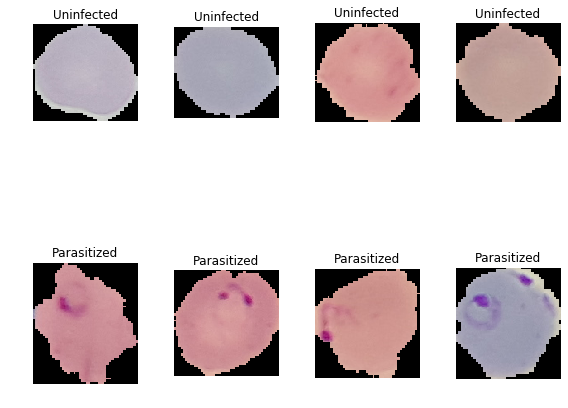

In [21]:
# Define the directories to iterate over
directories = ['Uninfected', 'Parasitized']
# Plot the first four images from both directories
plt.figure(figsize=(8, 8))

for i, directory in enumerate(directories):
    # Path to the current directory
    dir_path = os.path.join(train_path, directory)
    
    # List of image files in the directory
    files = os.listdir(dir_path)[:4]  # Select first four images
    
    # Plot the images
    for j, filename in enumerate(files):
        image_path = os.path.join(dir_path, filename)
        image = imread(image_path)
        
        # Calculate the position of the subplot
        position = i*4 + j + 1
        
        # Plot the image
        plt.subplot(2, 4, position)
        plt.imshow(image)
        plt.title(directory)
        plt.axis('off')
plt.tight_layout()
plt.show()

**Let's check how many images there are.**

In [13]:
len(os.listdir(train_path+'/Parasitized'))

13780

In [14]:
len(os.listdir(train_path+'/Uninfected'))

13780

**Let's find out the average dimensions of these images.**

In [23]:
unifected_cell_path = train_path+'/Parasitized/'+os.listdir(train_path+'//Parasitized')[0]
unifected_cell = imread(unifected_cell_path)
unifected_cell.shape

(151, 130, 3)

In [27]:
Parasitized_cell_path = train_path+'/Parasitized/'+os.listdir(train_path+'//Parasitized')[2]
Parasitized_cell = imread(Parasitized_cell_path)
Parasitized_cell.shape

(130, 124, 3)

In [19]:
np.mean(dim1)

131.69187817258884

In [21]:
image_shape = (130,130,3)

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [24]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

In [28]:
image_gen.flow_from_directory(train_path)

Found 27558 images belonging to 2 classes.


In [29]:
image_gen.flow_from_directory(test_path)

Found 15832 images belonging to 2 classes.


# Creating the Model

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
import warnings
warnings.filterwarnings("ignore")

In [31]:
# Initialising the CNN
classifier = Sequential()

#1 - Convolution
classifier.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

#2 - Pooling
# Hidden Layer 1
classifier.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

# Adding a second convolution layer
# relu turns negative values in images to 0
classifier.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

#3 - Flattening
# converts the matrix in a singe array
classifier.add(Flatten())


classifier.add(Dense(128))
classifier.add(Activation('relu'))


# Dropouts help reduce overfitting by randomly turning neurons off during training.
# Here we say randomly turn off 50% of neurons.
classifier.add(Dropout(0.5))

#4 - Full Connection
# 128 is the final layer of outputs & from that 1 will be considered.
# Last layer, remember its binary so we use sigmoid
classifier.add(Dense(1))
classifier.add(Activation('sigmoid'))

classifier.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [32]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

## Early Stopping

In [33]:
from tensorflow.keras.callbacks import EarlyStopping

In [34]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

## Training the Model

In [35]:
batch_size = 16

In [36]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 27558 images belonging to 2 classes.


In [37]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 15832 images belonging to 2 classes.


In [38]:
train_image_gen.class_indices

{'Parasitized': 0, 'Uninfected': 1}

In [39]:
results = classifier.fit_generator(train_image_gen,epochs=20,
                              validation_data=test_image_gen,
                             callbacks=[early_stop])

Train for 1723 steps, validate for 990 steps
Epoch 1/20
1723/1723 [==============================] - 292s 169ms/step - loss: 0.4022 - accuracy: 0.8058 - val_loss: 0.1910 - val_accuracy: 0.9346
Epoch 2/20
1723/1723 [==============================] - 221s 128ms/step - loss: 0.1807 - accuracy: 0.9440 - val_loss: 0.1640 - val_accuracy: 0.9459
Epoch 3/20
1723/1723 [==============================] - 221s 128ms/step - loss: 0.1683 - accuracy: 0.9485 - val_loss: 0.1579 - val_accuracy: 0.9474
Epoch 4/20
1723/1723 [==============================] - 218s 127ms/step - loss: 0.1592 - accuracy: 0.9509 - val_loss: 0.1588 - val_accuracy: 0.9448
Epoch 5/20
1723/1723 [==============================] - 222s 129ms/step - loss: 0.1605 - accuracy: 0.9491 - val_loss: 0.1803 - val_accuracy: 0.9432


> I used 0.5 or 50% dropping of neurons while training to avoid overfitting problem (dropout)

In [40]:
from tensorflow.keras.models import load_model
classifier.save('malaria_detector.h5')

# Evaluating the Model

In [41]:
losses = pd.DataFrame(classifier.history.history)

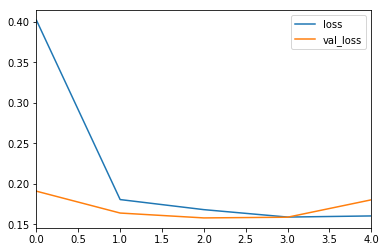

In [42]:
losses[['loss','val_loss']].plot()

In [43]:
classifier.metrics_names

['loss', 'accuracy']

In [44]:
classifier.evaluate_generator(test_image_gen)

[0.18223075606234634, 0.9433426]

In [45]:
from tensorflow.keras.preprocessing import image

In [46]:
pred_probabilities = classifier.predict_generator(test_image_gen)

In [47]:
pred_probabilities

array([[0.02395803],
       [0.00824055],
       [0.00126198],
       ...,
       [0.99150836],
       [0.9886198 ],
       [0.9515345 ]], dtype=float32)

In [48]:
test_image_gen.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [49]:
predictions = pred_probabilities > 0.5

In [50]:
# Numpy can treat this as True/False for us
predictions

array([[False],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

In [51]:
from sklearn.metrics import classification_report,confusion_matrix

In [52]:
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.98      0.91      0.94      7952
           1       0.92      0.98      0.95      7880

    accuracy                           0.94     15832
   macro avg       0.95      0.94      0.94     15832
weighted avg       0.95      0.94      0.94     15832



In [53]:
confusion_matrix(test_image_gen.classes,predictions)

array([[7243,  709],
       [ 166, 7714]])